In [1]:
# compare the data/mc for cluster modelling to evaluate signal uncertainty and correction

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import scipy
from scipy import stats
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [4]:
fpath =OrderedDict()
tree = OrderedDict()

data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v140/normalized/'
bkg_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v140/normalized/'
# sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v4/normalized/'


lumi = 41.53*1000

fpath['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
fpath['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    a = tree[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)


dy_120_800 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v140/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
[-8.627941  -1.2055961 -0.1042499  0.1042499  1.2055961  8.627941 ]
(143420,)
data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v140/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
[41530.]
(354744,)


### Load Variables and TnP Selections

In [33]:
%%time

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
dtRechitClusterEta = {}
dtRechitClusterSize = {}
dtRechitClusterNStation10 = {}
dtRechitClusterAvgStation10 = {}
mc_corr_weight = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
lepSF = {}
cond = {}
dtRechitClusterEta = {}
sel_tp = {}
probe_index = {}
dtRechitCluster_match_dtSeg_0p5 = {}
dtRechitCluster_match_dtSegTime_0p5  = {}
dtRechitCluster_match_dtSeg_0p4  = {}
dtRechitCluster_match_dtSegTime_0p4 = {}
dtRechitCluster_match_dtSegTimeSpread_0p5  = {}
dtRechitCluster_match_dtSegTimeSpread_0p4  = {}
dtRechitClusterMaxStation = {}
dtRechitCluster_match_dtSeg_sameStation_0p5  = {}
dtRechitCluster_match_dtSegTime_sameStation_0p5  = {}
dtRechitCluster_match_dtSeg_sameStation_0p4  = {}
dtRechitCluster_match_dtSegTime_sameStation_0p4 = {}
dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5  = {}
dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4  = {}

dtRechitCluster_match_RPCTime_dPhi0p5  = {}
dtRechitCluster_match_RPCTimeSpread_dPhi0p5  = {}
dtRechitCluster_match_RPChits_dPhi0p5   = {}
dtRechitCluster_match_RPCTime_dR0p4  = {}
dtRechitCluster_match_RPCTimeSpread_dR0p4  = {}
dtRechitCluster_match_RPChits_dR0p4  = {}
dtRechitCluster_match_RPCTime_sameStation_dR0p4   = {}
dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4  = {}
dtRechitCluster_match_RPChits_sameStation_dR0p4  = {}
dtRechitClusterMuonVetoPt = {}

dtRechitCluster_match_RPCBx_dR0p4 = {}
dtRechitCluster_match_RPCBx_sameStation_dR0p4 = {}
dtRechitCluster_match_RPCBx_dPhi0p5 = {}

dtRechitCluster_match_RPCBx_dR0p4_median = {}
dtRechitCluster_match_RPCBx_sameStation_dR0p4_median = {}
dtRechitCluster_match_RPCBx_dPhi0p5_median = {}
dtRechitCluster_match_RPCBx_dR0p4_mode = {}
dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode = {}
dtRechitCluster_match_RPCBx_dPhi0p5_mode = {}
dtRechitCluster_match_RPCBx_dR0p4_count = {}
dtRechitCluster_match_RPCBx_sameStation_dR0p4_count = {}
dtRechitCluster_match_RPCBx_dPhi0p5_count = {}
nDtSectors = {}
test = {}
muonPt = 50
norm = 50
tag_probe = True
for k, T in tree.items():
########## select cluster ########

    sel_cluster = np.abs(T.array('dtRechitClusterSize'))>=50
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('dtRechitClusterTimeSpread'))<20)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('dtRechitClusterMaxStation')) > 1)
#         sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('dtRechitClusterEta')) < 2.0)    
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('dtRechitClusterMuonVetoPt')) > muonPt)
    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('dtRechitClusterZLep1') == 1, T.array('dtRechitClusterZLep2') == 1))
    if k[:2] == 'dy':sel_cluster = np.logical_and(sel_cluster, T.array('dtRechitClusterGenMuonVetoPt') > muonPt)
    sel_cluster1 =np.logical_and(sel_cluster,  T.array('dtRechitClusterZLep1') == 1)   #loose lepton
    sel_cluster2 = np.logical_and(sel_cluster,  T.array('dtRechitClusterZLep2') == 1)  

# ########### BRANCHES ############
    sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
    sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
    sel_ev[k] = sel_lep[k].sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
    if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<800)

    probe_index[k] = []
    sel_tp[k] = []
    cond[k] = []
    sel_probecluster = []
    pdgid = T.array("lepPdgId")


    index = 0
    for i, ev in enumerate(sel_ev[k]):
        if ev:
            if sel_lep[k][i][0]:
                probe_index[k].append([False,True])
                sel_tp[k].append(index)
                if pdgid[i][0] == 13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]: sel_probecluster.append(list(sel_cluster2[i]))
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
            if sel_lep[k][i][1]:
                probe_index[k].append([True, False])
                sel_tp[k].append(index)
                if pdgid[i][0] == -13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]:sel_probecluster.append(list(sel_cluster2[i]))
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
            index+=1
    sel_tp[k] = np.array(sel_tp[k])
    probe_index[k] = np.array(probe_index[k])
    cond[k] = np.array(cond[k])
    sel_probecluster = awkward.fromiter(sel_probecluster)

    weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
    pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
#         if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]]
#         if k[:2] == 'dy': lepOverallSF[k] = pileupWeight[k]*0.0+1.0



    ZMass[k]= T.array('ZMass')[sel_ev[k]][sel_tp[k]]
    ZPt[k] = T.array('ZPt')[sel_ev[k]][sel_tp[k]]
    mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
    # with pT > 50
    if norm == 50:
        mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
        mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
        mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
        mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 0.91870093
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1795386
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.5143042
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4587245

    lepE[k] = np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
    lepEta[k] = np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
    lepPt[k] = np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]])[probe_index[k]]

#         if k[:2] == 'dy':lepSF[k] = np.array(T.array('lepSF')[sel_ev[k]][sel_tp[k]])[probe_index[k]]


    if k[:4] == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
        mc_corr_weight[k] = weight[k] * 0.0 + 1.0

    dtRechitClusterEta[k] = awkward.fromiter(T.array('dtRechitClusterEta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitClusterMuonVetoPt[k] = awkward.fromiter(T.array('dtRechitClusterMuonVetoPt')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitClusterSize[k] = awkward.fromiter(T.array('dtRechitClusterSize')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitClusterNStation10[k] = awkward.fromiter(T.array('dtRechitClusterNStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitClusterAvgStation10[k] = awkward.fromiter(T.array('dtRechitClusterAvgStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    dtRechitClusterMaxStation[k] = awkward.fromiter(T.array('dtRechitClusterMaxStation')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]




    dtRechitCluster_match_dtSeg_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSeg_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTime_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTime_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSeg_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSeg_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTime_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTime_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTimeSpread_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTimeSpread_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTimeSpread_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTimeSpread_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    dtRechitCluster_match_dtSeg_sameStation_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSeg_sameStation_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTime_sameStation_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTime_sameStation_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSeg_sameStation_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSeg_sameStation_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTime_sameStation_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTime_sameStation_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    dtRechitCluster_match_RPCTime_dPhi0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTime_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0] * 25
    dtRechitCluster_match_RPCTimeSpread_dPhi0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTimeSpread_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]* 25
    dtRechitCluster_match_RPChits_dPhi0p5[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_RPCTime_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTime_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]* 25
    dtRechitCluster_match_RPCTimeSpread_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTimeSpread_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]* 25
    dtRechitCluster_match_RPChits_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    dtRechitCluster_match_RPCTime_sameStation_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTime_sameStation_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]* 25
    dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]* 25
    dtRechitCluster_match_RPChits_sameStation_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_sameStation_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    
#     dtRechitCluster_match_RPCBx_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCBx_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
#     dtRechitCluster_match_RPCBx_sameStation_dR0p4[k]  = awkward.fromiter(T.array('dtRechitCluster_match_RPCBx_sameStation_dR0p4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
#     dtRechitCluster_match_RPCBx_dPhi0p5[k] = awkward.fromiter(T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    
#     dtRechitCluster_match_RPCBx_dR0p4_median[k] = [np.median(x) for x in dtRechitCluster_match_RPCBx_dR0p4[k]]
#     dtRechitCluster_match_RPCBx_dR0p4_mode[k] = [scipy.stats.mode(x)[0] for x in dtRechitCluster_match_RPCBx_dR0p4[k]]
#     dtRechitCluster_match_RPCBx_dR0p4_count[k] = [scipy.stats.mode(x)[1] for x in dtRechitCluster_match_RPCBx_dR0p4[k]]

#     dtRechitCluster_match_RPCBx_sameStation_dR0p4_median[k] = [np.median(x) for x in dtRechitCluster_match_RPCBx_sameStation_dR0p4[k]]
#     dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode[k] = [scipy.stats.mode(x)[0] for x in dtRechitCluster_match_RPCBx_sameStation_dR0p4[k]]
#     dtRechitCluster_match_RPCBx_sameStation_dR0p4_count[k] = [scipy.stats.mode(x)[1] for x in dtRechitCluster_match_RPCBx_sameStation_dR0p4[k]]
    
#     dtRechitCluster_match_RPCBx_dPhi0p5_median[k] = [np.median(x) for x in dtRechitCluster_match_RPCBx_dPhi0p5[k]]
#     dtRechitCluster_match_RPCBx_dPhi0p5_mode[k] = [scipy.stats.mode(x)[0] for x in dtRechitCluster_match_RPCBx_dPhi0p5[k]]
#     dtRechitCluster_match_RPCBx_dPhi0p5_count[k] = [scipy.stats.mode(x)[1] for x in dtRechitCluster_match_RPCBx_dPhi0p5[k]]
    
    
    
    nDtSectors[k] = np.sum(np.reshape(T.array('nDTRechitsSector')>=3, (-1,4*5*12)), axis = 1)[sel_ev[k]][sel_tp[k]]


print(len(weight['data'])/ np.sum(weight['dy_120_800']*pileupWeight['dy_120_800']*mc_corr_weight['dy_120_800']))
print(len(weight['data'][cond['data']])/ np.sum((weight['dy_120_800']*pileupWeight['dy_120_800']*mc_corr_weight['dy_120_800'])[cond['dy_120_800']]))



0.9964879224890397
1.236867984528404
CPU times: user 1min 16s, sys: 657 ms, total: 1min 17s
Wall time: 1min 17s


dy_120_800 27626.228853808076
data 34170.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


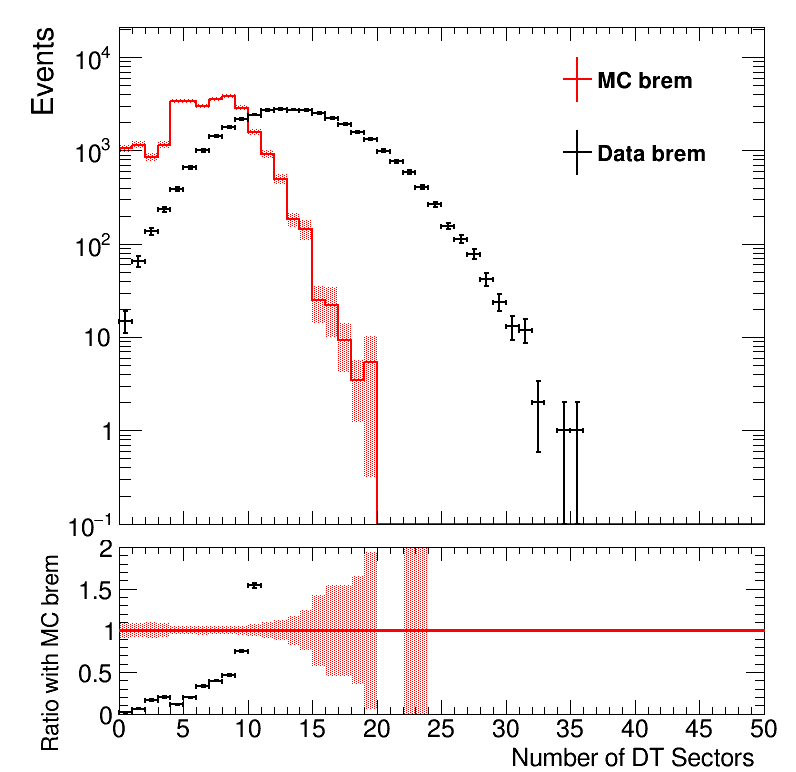

In [42]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
m1 = 120
m2 = 800
keys = ['dy_120_800', 'data']


dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu'+'/'

      
for i, k in enumerate(cond.keys()):
    total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
    hm[k] = create_TH1D(nDtSectors[k][cond[k]], k, axis_title = ['Number of DT Sectors','Events'], binning=[50,0,50], weights = total_weight[cond[k]])

#     hm[k] = create_TH1D(nDtSectors[k].flatten(), k, axis_title = ['Number of DT Sectors','Events'], binning=[50,0,50], weights = total_weight)
#     hm[k] = create_TH1D(lepE[k], k, axis_title = ['Number of DT Sectors','Events'], binning=[50,0,500], weights = total_weight)



    print(k, hm[k].Integral())
    hm[k].SetLineColor(std_color_list[1-i])
c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
# else:c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
c.Draw()
#     c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.png')
#     c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.C')
  





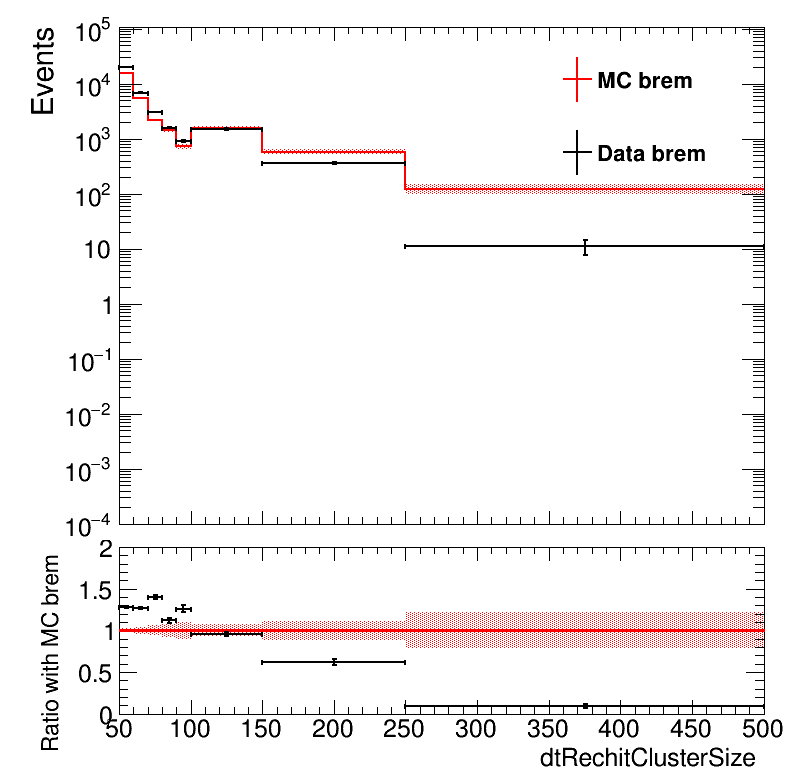

In [5]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
m1 = 120
m2 = 800
keys = ['dy_120_800', 'data']

var = [dtRechitClusterEta, dtRechitClusterMaxStation, dtRechitClusterSize, dtRechitClusterMuonVetoPt]
names = ['dtRechitClusterEta', 'dtRechitClusterMaxStation', 'dtRechitClusterSize', 'dtRechitClusterMuonVetoPt']
title = ['dtRechitClusterEta', 'dtRechitClusterMaxStation', 'dtRechitClusterSize', 'dtRechitClusterMuonVetoPt']
bins = [[50,-1.5,1.5],[5,0,5],[50,60,70,80,90,100,150,250,500],[50,0,1000]]
# clusterSize_bins = [0, 10, 20, 30, 40, 50, 60, 70, 100, 150, 250, 500]
# if rechit_cut[sig_ver]< 70: clusterSize_bins += [70]
# clusterSize_bins += [100, 150, 250, 500]
assert(len(var) == len(title) == len(names) == len(bins) )

dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu'+'/'


for j in range(len(var)):
      
    if not j == 2:continue
    for i, k in enumerate(cond.keys()):
        total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
#         hm[k] = create_TH1D(var[j][k], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]])
#         print(hm[k].Integral(), np.sum(total_weight[cond[k]]))
        hm[k] = create_TH1D(var[j][k].flatten(), k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]])
#         print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][hits[j][k]>0])/np.sum(total_weight[cond[k]]))
#         test = np.logical_and(var[j][k]<12.5, var[j][k]>-5)
#         test = np.logical_and(test, hits[j][k]>0)
#         print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][test])/np.sum(total_weight[cond[k]][hits[j][k]>0]))


        hm[k].SetLineColor(std_color_list[1-i])
#         hm[k].Scale(1./hm[k].Integral())
#         hm[k].Fit('gaus',"","",-5,5)
#         print(r.Get().Parameter(2))
#         print(k, hm[k].Integral(), np.sum(total_weight[cond[k]]), len(total_weight[cond[k]]))
    if j > 1:c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
    else:c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
    c.Draw()
#     c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.png')
#     c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.C')
  




dtRechitCluster_match_RPCBx_dR0p4_median dy_120_800 0.9970789
dtRechitCluster_match_RPCBx_dR0p4_median data 0.9987689
dtRechitCluster_match_RPCBx_sameStation_dR0p4_median dy_120_800 0.9900823
dtRechitCluster_match_RPCBx_sameStation_dR0p4_median data 0.9947031
dtRechitCluster_match_RPCBx_dPhi0p5_median dy_120_800 0.9951182
dtRechitCluster_match_RPCBx_dPhi0p5_median data 0.99738646
dtRechitCluster_match_RPCBx_dR0p4_mode dy_120_800 0.9974836
dtRechitCluster_match_RPCBx_dR0p4_mode data 0.9982999
dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode dy_120_800 0.9900748
dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode data 0.99395967
dtRechitCluster_match_RPCBx_dPhi0p5_mode dy_120_800 0.99519414
dtRechitCluster_match_RPCBx_dPhi0p5_mode data 0.9967697


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSegTime_0p5_Zmass120_800_muon50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSegTime_0p5_Zmass120_800_muon50.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSegTime_0p4_Zmass120_800_muon50.png

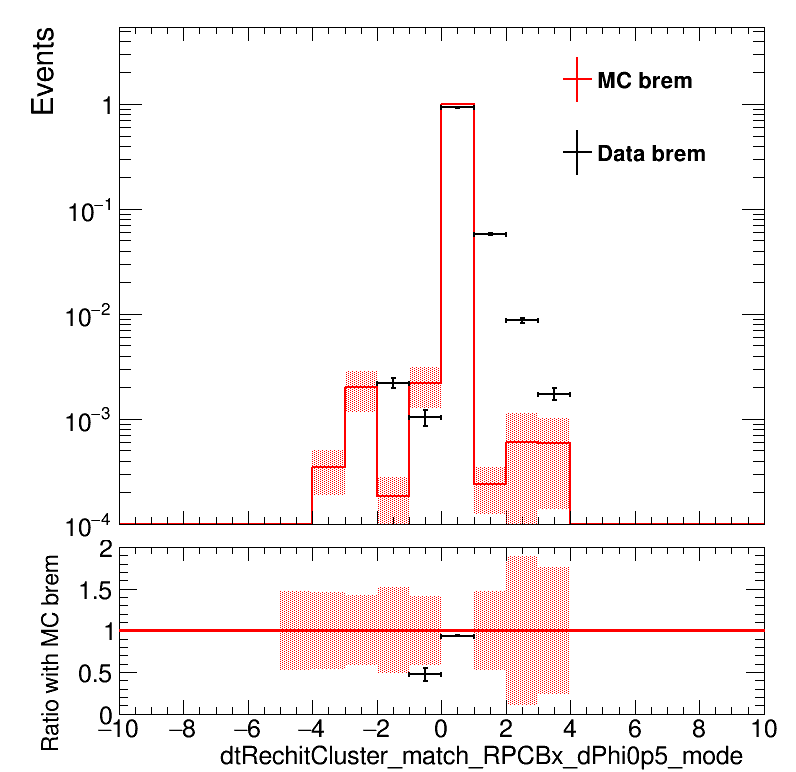

In [24]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
m1 = 120
m2 = 800
keys = ['dy_120_800', 'data']

var = [dtRechitCluster_match_dtSegTime_0p5, dtRechitCluster_match_dtSegTime_0p4, dtRechitCluster_match_dtSegTime_sameStation_0p5, dtRechitCluster_match_dtSegTime_sameStation_0p4, \
              dtRechitCluster_match_RPCTime_dPhi0p5, dtRechitCluster_match_RPCTime_dR0p4, dtRechitCluster_match_RPCTime_sameStation_dR0p4,\
      dtRechitCluster_match_RPCBx_dR0p4_median, dtRechitCluster_match_RPCBx_sameStation_dR0p4_median, dtRechitCluster_match_RPCBx_dPhi0p5_median, \
      dtRechitCluster_match_RPCBx_dR0p4_mode, dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode, dtRechitCluster_match_RPCBx_dPhi0p5_mode]
names = ['dtRechitCluster_match_dtSegTime_0p5', 'dtRechitCluster_match_dtSegTime_0p4', 'dtRechitCluster_match_dtSegTime_sameStation_0p5', 'dtRechitCluster_match_dtSegTime_sameStation_0p4', \
              'dtRechitCluster_match_RPCTime_dPhi0p5', 'dtRechitCluster_match_RPCTime_dR0p4', 'dtRechitCluster_match_RPCTime_sameStation_dR0p4',\
        'dtRechitCluster_match_RPCBx_dR0p4_median', 'dtRechitCluster_match_RPCBx_sameStation_dR0p4_median', 'dtRechitCluster_match_RPCBx_dPhi0p5_median', \
      'dtRechitCluster_match_RPCBx_dR0p4_mode', 'dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode', 'dtRechitCluster_match_RPCBx_dPhi0p5_mode']
title =  ['dtRechitCluster_match_dtSegTime_0p5', 'dtRechitCluster_match_dtSegTime_0p4', 'dtRechitCluster_match_dtSegTime_sameStation_0p5', 'dtRechitCluster_match_dtSegTime_sameStation_0p4', \
              'dtRechitCluster_match_RPCTime_dPhi0p5', 'dtRechitCluster_match_RPCTime_dR0p4', 'dtRechitCluster_match_RPCTime_sameStation_dR0p4',\
        'dtRechitCluster_match_RPCBx_dR0p4_median', 'dtRechitCluster_match_RPCBx_sameStation_dR0p4_median', 'dtRechitCluster_match_RPCBx_dPhi0p5_median', \
      'dtRechitCluster_match_RPCBx_dR0p4_mode', 'dtRechitCluster_match_RPCBx_sameStation_dR0p4_mode', 'dtRechitCluster_match_RPCBx_dPhi0p5_mode']

hits = [dtRechitCluster_match_dtSeg_0p5, dtRechitCluster_match_dtSeg_0p4, dtRechitCluster_match_dtSeg_sameStation_0p5, dtRechitCluster_match_dtSeg_sameStation_0p4, \
              dtRechitCluster_match_RPChits_dPhi0p5, dtRechitCluster_match_RPChits_dR0p4, dtRechitCluster_match_RPChits_sameStation_dR0p4, \
           dtRechitCluster_match_RPChits_dR0p4, dtRechitCluster_match_RPChits_sameStation_dR0p4, dtRechitCluster_match_RPChits_dPhi0p5,\
           dtRechitCluster_match_RPChits_dR0p4, dtRechitCluster_match_RPChits_sameStation_dR0p4, dtRechitCluster_match_RPChits_dPhi0p5]


bins = [[50,-25,25]]*4 + [[50,-25,25]]*3 + [[20,-10,10]]*6

assert(len(var) == len(title) == len(names) == len(bins) )

dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu'+'/'


for j in range(len(var)):
      
#     if not j == 10:continue
    for i, k in enumerate(cond.keys()):
        total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
        if j >=10: 
            hm[k] = create_TH1D(np.concatenate(var[j][k]).ravel(), k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][hits[j][k]>0])
        else:
            hm[k] = create_TH1D(var[j][k], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]])

            
        if j >= 10:
            weight_temp = total_weight[cond[k]][hits[j][k]>0]
            var_temp = np.concatenate(var[j][k]).ravel()
            print(names[j], k, np.sum(weight_temp[var_temp>=0.0])/np.sum(weight_temp))
        elif j >= 7:
            weight_temp = total_weight[cond[k]][hits[j][k]>0]
#             var_temp = np.concatenate(var[j][k]).ravel()
            var_temp = np.array(var[j][k])[hits[j][k]>0]
            print(names[j], k, np.sum(weight_temp[var_temp>=0.0])/np.sum(weight_temp))
#         hm[k] = create_TH1D(var[j][k][hits[j][k]>0], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][hits[j][k]>0])
#         print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][hits[j][k]>0])/np.sum(total_weight[cond[k]]))
#         test=  np.logical_and(dtRechitCluster_match_dtSegTimeSpread_0p5[k]<10, hits[j][k]>0)
#         hm[k] = create_TH1D(var[j][k][test], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][test])

    
        
#         test = np.logical_and(var[j][k]<12.5, var[j][k]>-5)
#         test = np.logical_and(test, hits[j][k]>0)
#         print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][test])/np.sum(total_weight[cond[k]][hits[j][k]>0]))


        hm[k].SetLineColor(std_color_list[1-i])
        hm[k].Scale(1./hm[k].Integral())
#         hm[k].Fit('gaus',"","",-5,5)
#         result = hm[k].FindObject('gaus')
#         print(k, result.GetParameter(0), result.GetParameter(1), result.GetParameter(2))
#         print(r.Get().Parameter(2))
#         print(k, hm[k].Integral(), np.sum(total_weight[cond[k]]), len(total_weight[cond[k]]))
    c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
    c.Draw()
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.png')
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.C')
  





92
dy_120_800 0.9999999427921296 27626.23 14811
93
data 0.9999999737920007 34170.0 34170
92
dy_120_800 0.9999999427921296 27626.23 14811
93
data 0.9999999737920007 34170.0 34170
88
dy_120_800 0.9999999427921296 27626.23 14811
90
data 0.9999999737920007 34170.0 34170
88
dy_120_800 0.9999999427921296 27626.23 14811
90
data 0.9999999737920007 34170.0 34170
22
dy_120_800 0.9999999427921296 27626.23 14811
56
data 0.9997951157347416 34170.0 34170
28
dy_120_800 0.9999999427921296 27626.23 14811
56
data 0.9998243811714929 34170.0 34170
14
dy_120_800 0.9999999427921296 27626.23 14811
39
data 0.9999999737920007 34170.0 34170


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSeg_0p5_Zmass120_800_muon50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSeg_0p5_Zmass120_800_muon50.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSeg_0p4_Zmass120_800_muon50.png has been cr

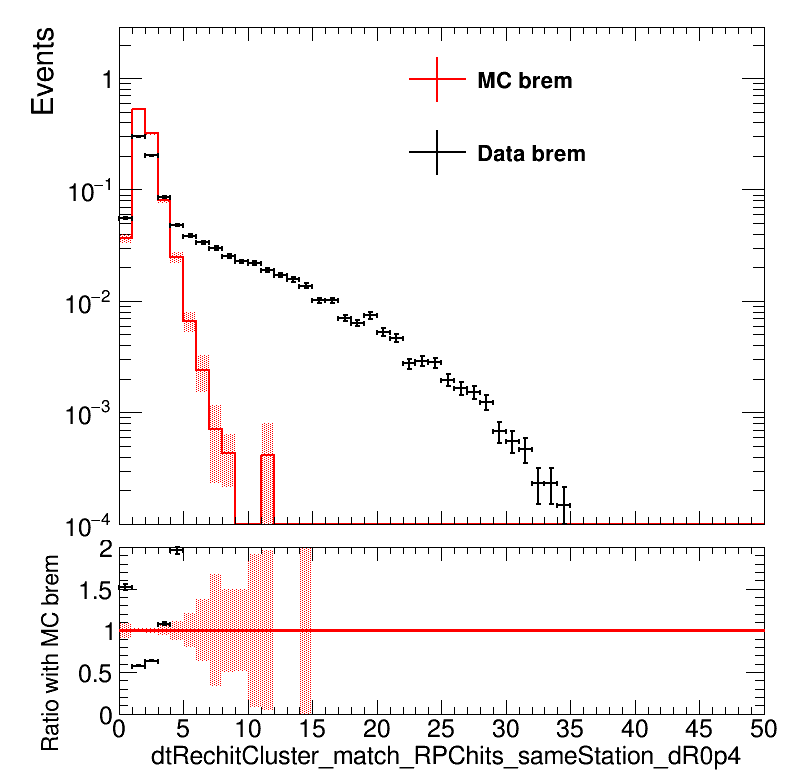

In [298]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
m1 = 120
m2 = 800
keys = ['dy_120_800', 'data']

var = [dtRechitCluster_match_dtSeg_0p5, dtRechitCluster_match_dtSeg_0p4, dtRechitCluster_match_dtSeg_sameStation_0p5, dtRechitCluster_match_dtSeg_sameStation_0p4, \
              dtRechitCluster_match_RPChits_dPhi0p5, dtRechitCluster_match_RPChits_dR0p4, dtRechitCluster_match_RPChits_sameStation_dR0p4]
names = ['dtRechitCluster_match_dtSeg_0p5', 'dtRechitCluster_match_dtSeg_0p4', 'dtRechitCluster_match_dtSeg_sameStation_0p5', 'dtRechitCluster_match_dtSeg_sameStation_0p4', \
              'dtRechitCluster_match_RPChits_dPhi0p5', 'dtRechitCluster_match_RPChits_dR0p4', 'dtRechitCluster_match_RPChits_sameStation_dR0p4']
title = ['dtRechitCluster_match_dtSeg_0p5', 'dtRechitCluster_match_dtSeg_0p4', 'dtRechitCluster_match_dtSeg_sameStation_0p5', 'dtRechitCluster_match_dtSeg_sameStation_0p4', \
              'dtRechitCluster_match_RPChits_dPhi0p5', 'dtRechitCluster_match_RPChits_dR0p4', 'dtRechitCluster_match_RPChits_sameStation_dR0p4']
bins = [[50,0, 100]]*4 + [[50,0,50]]*3

assert(len(var) == len(title) == len(names) == len(bins) )

dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu'+'/'
# '_norm'+str(norm)+'_'+ver+sig_ver
# if tag_probe: dir_name+="_tag_probe"
# dir_name += '/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)


for j in range(len(var)):
      
    if not j == 5:continue
    for i, k in enumerate(cond.keys()):
        total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
        hm[k] = create_TH1D(var[j][k], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]]/np.sum(total_weight[cond[k]]))
        hm[k].SetLineColor(std_color_list[1-i])
        print(np.max(var[j][k]))
        print(k, hm[k].Integral(), np.sum(total_weight[cond[k]]), len(total_weight[cond[k]]))
    c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
    c.Draw()
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.png')
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.C')
  







## time spread

dtRechitCluster_match_dtSegTimeSpread_0p5 	 dy_120_800 	 0.46996304
dtRechitCluster_match_dtSegTimeSpread_0p5 	 data 	 0.44814664


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSegTimeSpread_0p5_Zmass120_800_muon50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu/dtRechitCluster_match_dtSegTimeSpread_0p5_Zmass120_800_muon50.C has been generated


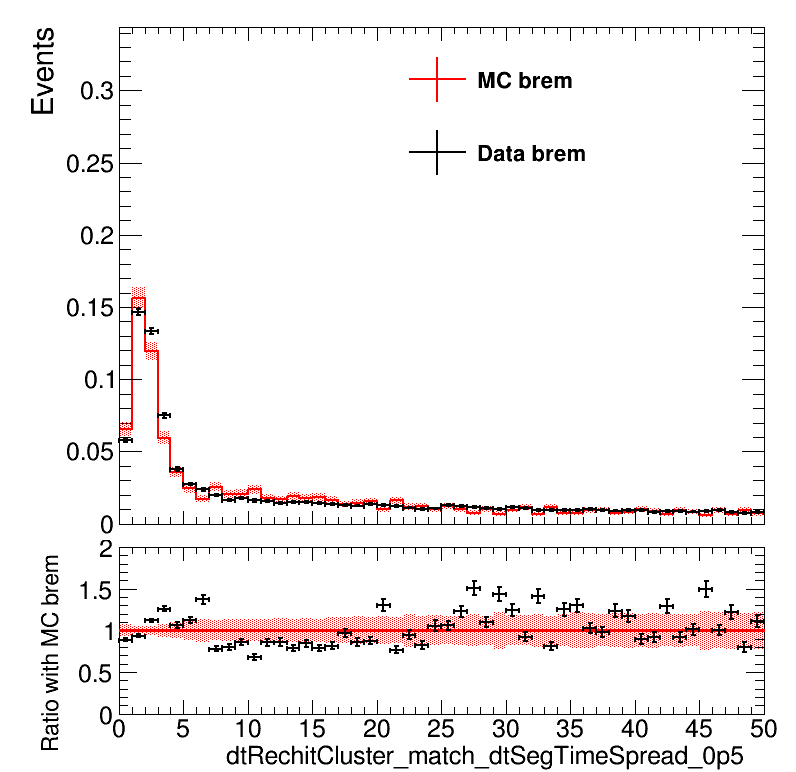

In [216]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
m1 = 120
m2 = 800
keys = ['dy_120_800', 'data']

var = [dtRechitCluster_match_dtSegTimeSpread_0p5, dtRechitCluster_match_dtSegTimeSpread_0p4, dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5, dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4, \
              dtRechitCluster_match_RPCTimeSpread_dPhi0p5, dtRechitCluster_match_RPCTimeSpread_dR0p4, dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4]
names = ['dtRechitCluster_match_dtSegTimeSpread_0p5', 'dtRechitCluster_match_dtSegTimeSpread_0p4', 'dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5', 'dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4', \
              'dtRechitCluster_match_RPCTimeSpread_dPhi0p5', 'dtRechitCluster_match_RPCTimeSpread_dR0p4', 'dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4']
title = ['dtRechitCluster_match_dtSegTimeSpread_0p5', 'dtRechitCluster_match_dtSegTimeSpread_0p4', 'dtRechitCluster_match_dtSegTimeSpread_sameStation_0p5', 'dtRechitCluster_match_dtSegTimeSpread_sameStation_0p4', \
              'dtRechitCluster_match_RPCTimeSpread_dPhi0p5', 'dtRechitCluster_match_RPCTimeSpread_dR0p4', 'dtRechitCluster_match_RPCTimeSpread_sameStation_dR0p4']

hits = [dtRechitCluster_match_dtSeg_0p5, dtRechitCluster_match_dtSeg_0p4, dtRechitCluster_match_dtSeg_sameStation_0p5, dtRechitCluster_match_dtSeg_sameStation_0p4, \
              dtRechitCluster_match_RPChits_dPhi0p5, dtRechitCluster_match_RPChits_dR0p4, dtRechitCluster_match_RPChits_sameStation_dR0p4]

bins = [[50,0,50]]*4 + [[50,0,25]]*3

assert(len(var) == len(title) == len(names) == len(bins) )

dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/cluster_time_ZToMuMu'+'/'


for j in range(len(var)):
      
    if not j == 0:continue
    for i, k in enumerate(cond.keys()):
        total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
#         hm[k] = create_TH1D(var[j][k], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]])
#         print(hm[k].Integral(), np.sum(total_weight[cond[k]]))
        hm[k] = create_TH1D(var[j][k][hits[j][k]>0], k, axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][hits[j][k]>0])
#         print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][hits[j][k]>0])/np.sum(total_weight[cond[k]]))
        
        
        test = np.logical_and(var[j][k]<10, hits[j][k]>0)
        print(names[j], '\t', k, '\t', np.sum(total_weight[cond[k]][test])/np.sum(total_weight[cond[k]][hits[j][k]>0]))


        hm[k].SetLineColor(std_color_list[1-i])
        hm[k].Scale(1./hm[k].Integral())
#         print(r.Get().Parameter(2))
#         print(k, hm[k].Integral(), np.sum(total_weight[cond[k]]), len(total_weight[cond[k]]))
    c = make_ratio_plot([hm[keys[0]],hm[keys[1]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
    c.Draw()
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.png')
    c.SaveAs(dir_name+names[j]+'_Zmass'+str(m1)+'_'+str(m2)+'_muon'+str(muonPt)+'.C')
  


